In [6]:
import sys
import os.path
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics
import keras.metrics
import keras.models
import keras.layers
import keras.optimizers
import keras.callbacks
import keras.utils.np_utils
import keras.preprocessing.sequence
import supervised_tools as tools
import warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
data_path = 'data'
if not os.path.exists(data_path):
    os.mkdir(data_path)
plot_path = 'plots'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)    
model_path = 'models'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
## Settings
do_knn = True
do_mlp = True
do_hg = True
'''Keep merge_data=True if you have set n_classes (in preprocessing) such that 
there are classes in the test set that do not have instances in the training set'''
merge_data = True 
sn = 3
'''This means that we are using all the features, 
if you want to limit the model to use only a subset of proncipal components, give them to this parameter as a list
The list should always include "id", "cycle", "status" columns'''
usecols = None
setnumber = 'FD00' + str(sn)

## KNN settings
# range of n_neighbors
n_range = np.array(range(1, 20))

## MLP settings
dense_width = 10
dense_depth = 1
dropout = 0.2
bs = 500 #batch size
epochs = 500

In [8]:
X_train, y_train, X_test, y_test, X_validate, y_validate, train, test, validate = \
tools.prepare_data(setnumber, usecols, merge_data=merge_data)

(24906, 21) (8294, 21) (8116, 21)


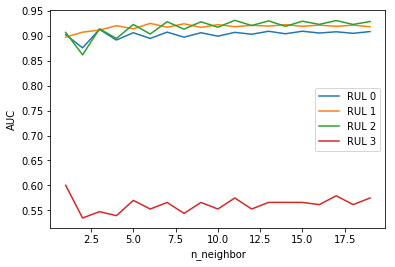

In [9]:
## KNN
if do_knn:
    aucs = np.zeros((len(n_range), y_test.shape[1]))
    for i, n in enumerate(n_range):
        KNN_model = tools.make_knn(n, X_train, y_train, X_test, y_test)
        aucs[i,:], y_pred = tools.make_prediction(KNN_model, X_test, y_test, fig=False)
    colors = ['b', 'g', 'r', 'm']
    plt.figure()
    for l in range(y_test.shape[1]):
        plt.plot(n_range, aucs[:,l], label='RUL %d'%l)
    plt.legend()
    plt.xlabel('n_neighbor')
    plt.ylabel('AUC')
    plt.show()

In [11]:
## MLP
if do_mlp:
    MLP_model = tools.make_mlp(train, X_train, dense_width, dense_depth, dropout)
    MLP_hist = tools.fit_mlp(MLP_model, X_train, y_train, X_validate, y_validate, bs, epochs)
    #MLP_model.save(os.path.join(model_path, 'MLP_model_%s_%d_%d_%.1f.h5'%(setnumber, dense_width, dense_depth, dropout)))

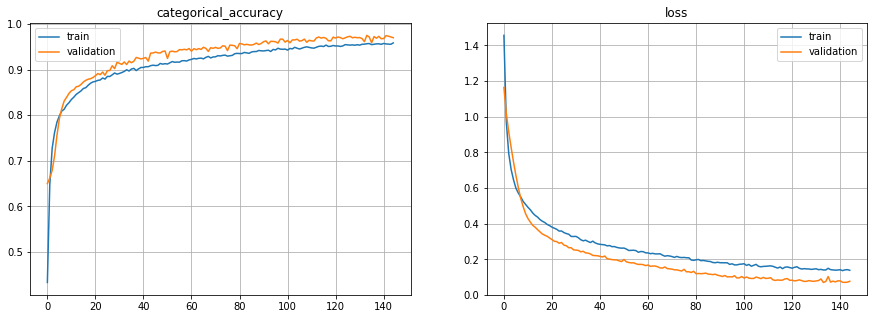

In [12]:
if do_mlp:
    MLP_auc = tools.plot_learning_curve(MLP_hist, setnumber, merge_data=merge_data)

In [13]:
## Hourglass
if do_hg:
    hg_model = tools.make_hourglass(train, X_train, dropout)
    hg_hist = tools.fit_mlp(hg_model, X_train, y_train, X_validate, y_validate, bs, epochs)
    #hg_model.save(os.path.join(model_path, 'hg_model_%s.h5'%(setnumber)))

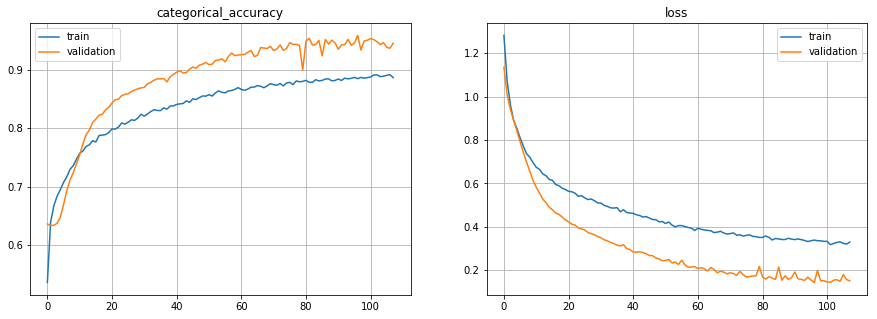

In [14]:
if do_hg:
    hg_auc = tools.plot_learning_curve(hg_hist, setnumber, merge_data)

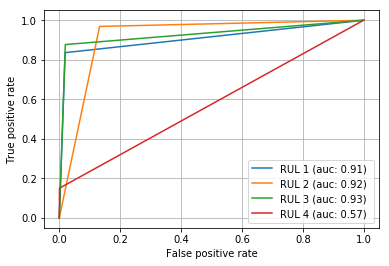

             precision    recall  f1-score   support

          0       0.87      0.84      0.85      1080
          1       0.94      0.97      0.95      5565
          2       0.90      0.88      0.89      1358
          3       0.74      0.15      0.25       113

avg / total       0.92      0.92      0.92      8116



In [15]:
if do_knn:
    aucs, y_pred_knn = tools.make_prediction(KNN_model, X_test, y_test, fig=True)
    y_knn = y_pred_knn
    print (sklearn.metrics.classification_report(y_test, y_knn))
    precision_knn, recall_knn, f1_knn, support_knn = sklearn.metrics.precision_recall_fscore_support(y_test, y_knn)
    y_knn_int = np.array([np.argmax(y_knn[i]) for i in range(len(y_knn))])

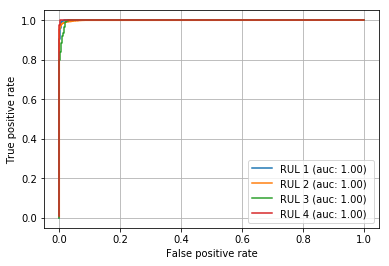

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1080
          1       0.98      0.99      0.99      5565
          2       0.92      0.95      0.94      1358
          3       0.00      0.00      0.00       113

avg / total       0.96      0.97      0.96      8116



In [16]:
if do_mlp:
    aucs, y_pred_mlp = tools.make_prediction(MLP_model, X_test, y_test, fig=True)
    y_mlp = keras.utils.np_utils.to_categorical(
        np.array([np.argmax(y_pred_mlp[i]) for i in range(len(y_pred_mlp))]),
        num_classes=train.status.nunique())
    print (sklearn.metrics.classification_report(y_test, y_mlp))
    precision_mlp, recall_mlp, f1_mlp, support_mlp = sklearn.metrics.precision_recall_fscore_support(y_test, y_mlp)
    y_mlp_int = np.array([np.argmax(y_mlp[i]) for i in range(len(y_mlp))])

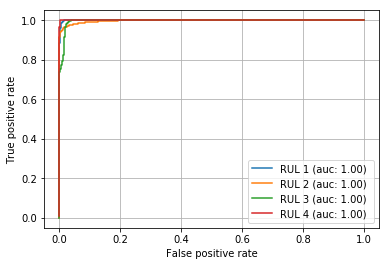

             precision    recall  f1-score   support

          0       0.86      1.00      0.92      1080
          1       0.99      0.96      0.98      5565
          2       0.90      0.97      0.94      1358
          3       0.00      0.00      0.00       113

avg / total       0.95      0.95      0.95      8116



In [17]:
if do_hg:
    aucs, y_pred_hg = tools.make_prediction(hg_model, X_test, y_test, fig=True)
    y_hg = keras.utils.np_utils.to_categorical(
        np.array([np.argmax(y_pred_hg[i]) for i in range(len(y_pred_hg))]), 
        num_classes=train.status.nunique())
    print (sklearn.metrics.classification_report(y_test, y_hg))
    precision_hg, recall_hg, f1_hg, support_hg = sklearn.metrics.precision_recall_fscore_support(y_test, y_hg)
    y_hg_int = np.array([np.argmax(y_hg[i]) for i in range(len(y_hg))])

In [18]:
y_test_int = np.array([np.argmax(y_test[i]) for i in range(len(y_test))])

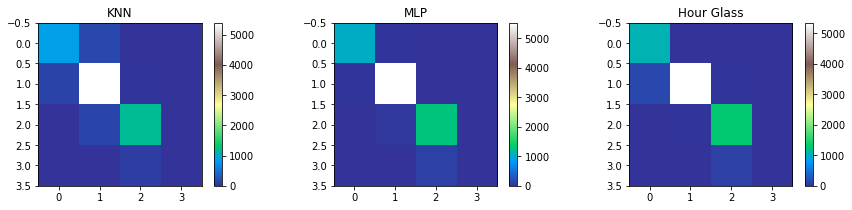

In [19]:
if do_knn and do_mlp and do_hg:
    cmap = 'terrain'
    fig, axs = plt.subplots(1,3, figsize=(15,3))
    axs = axs.flatten()
    cm_knn = axs[0].imshow(sklearn.metrics.confusion_matrix(y_test_int, y_knn_int), cmap=cmap)
    axs[0].set_title('KNN')
    plt.colorbar(mappable=cm_knn, ax=axs[0])
    cm_mlp = axs[1].imshow(sklearn.metrics.confusion_matrix(y_test_int, y_mlp_int), cmap=cmap)
    axs[1].set_title('MLP')
    plt.colorbar(mappable=cm_mlp, ax=axs[1])
    cm_hg = axs[2].imshow(sklearn.metrics.confusion_matrix(y_test_int, y_hg_int), cmap=cmap)
    axs[2].set_title('Hour Glass')
    plt.colorbar(mappable=cm_hg, ax=axs[2])
    plt.show()